# Chapter 09 — Compare CellBender to CellRanger

## Objective

In this chapter, we evaluate the performance of **CellBender** in removing ambient RNA compared to **CellRanger’s default filtering**. The focus is on assessing how each approach impacts data quality and cell recovery, and on preparing cleaned datasets for further analysis.

This includes:

- Reading AnnDatas from the CellBender and CellRanger outputs
- Plotting library size correlation plots between the two
- Plotting Venn Diagrams showing which cell barcodes are shared between the methods and which are unique
- Plotting UMAPs showing which cells are removed/gained by CellBender
- Identifying why these clusters may be removed (library size, low gene detection...)

### Data Inputs and Outputs

- CellBender AnnDatas will come from "adatas/combined_adatas_cellbender_raw_raw"
- CellRanger AnnDatas will come from combined_adatas_filtered_cells
- Figures will be outputted to "figures/chapter_09_compare_cellbender_to_cellranger


### How Does This Tie Back to the Big Picture (Comparing/Benchmarking Protocols)?

- Runnign CellBender will give us the metrics necessary to do ambient RNA analysis and will often remove "poor quality" cells. This will allow us to tell which protocol has more ambient RNA contamination or poor quality cells

- Seeing as we are comparing two debris removal protocols, ambient RNA analysis is particularly relevant to our benchmarking and will allow us to make a comparison between the protocols


<br>

---

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Core Imports

In [5]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List
from cellbender.remove_background.downstream import anndata_from_h5
import utils.config as config
import utils
from pprint import pprint

## File Paths and Metadata

In [10]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = os.path.join(
    DATA_DIR, "figures", "chapter_09_cellbender_basic_analysis"
)
RAW_FEATURE_BC_MATRIX_FILE_NAME = "raw_feature_bc_matrix.h5"

GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")

FIGURES_OUTPUT_DIR = os.path.join(
    DATA_DIR, "figures", "chapter_09_compare_cellbender_to_cellranger"
)

# Make sure figures output directory exists
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
INPUT_CELLBENDER_UNFILTERED_ADATA_DIR = os.path.join(DATA_DIR, "adatas", "adatas_X_cellbender_raw_raw")
INPUT_CELLBENDER_FILTERED_ADATA_DIR = os.path.join(DATA_DIR, "adatas", "adatas_X_cellbender_raw_filtered")
INPUT_CELLRANGER_ADATA_DIR = os.path.join(DATA_DIR, "adatas", "adatas_X_filtered_cells_gene_metrics_with_downsampled_layer")

INPUT_CELLRANGER_FILTERED_COMBINED_BY_TISSUE_DIR = os.path.join(
    DATA_DIR, "adatas", "combined_adatas_filtered_cells"
)


# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

### Read in AnnDatas

In [7]:
# Load AnnData objects
cellranger_adatas = {}
cellbender_filtered_adatas = {}
cellbender_unfiltered_adatas = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    cellranger_input_file_path = os.path.join(
        INPUT_CELLRANGER_ADATA_DIR, f"{key}_adata.h5ad"
    )
    cellbender_filtered_input_file_path = os.path.join(
        INPUT_CELLBENDER_FILTERED_ADATA_DIR, f"{key}_cellbender_corrected_output_filtered.h5"
    )
    cellbender_unfiltered_input_file_path = os.path.join(
        INPUT_CELLBENDER_UNFILTERED_ADATA_DIR, f"{key}_cellbender_corrected_output.h5"
    )

    cellranger_adata = sc.read_h5ad(cellranger_input_file_path)
    cellbender_filtered_adata = anndata_from_h5(
        file=cellbender_filtered_input_file_path
    )
    cellbender_unfiltered_adata = anndata_from_h5(
        file=cellbender_unfiltered_input_file_path
    )

    cellranger_adatas[key] = cellranger_adata
    cellbender_filtered_adatas[key] = cellbender_filtered_adata
    cellbender_unfiltered_adatas[key] = cellbender_unfiltered_adata

    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)

    print(f"{key}: {cellranger_adata}")
    print(f"{key}: {cellbender_filtered_adata}")
    print(f"{key}: {cellbender_unfiltered_adata}")

Assuming we are loading a "filtered" file that contains only cells.


/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


SF_N: AnnData object with n_obs × n_vars = 7179 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
SF_N: AnnData object with n_obs × n_vars = 6133 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swappi

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


SL_N: AnnData object with n_obs × n_vars = 7929 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
SL_N: AnnData object with n_obs × n_vars = 7668 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swappi

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


SF_T: AnnData object with n_obs × n_vars = 7146 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
SF_T: AnnData object with n_obs × n_vars = 5268 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swappi

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


SL_T: AnnData object with n_obs × n_vars = 8593 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
SL_T: AnnData object with n_obs × n_vars = 6851 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swappi

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


SF_LN: AnnData object with n_obs × n_vars = 5165 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
SF_LN: AnnData object with n_obs × n_vars = 5373 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swap

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


SL_LN: AnnData object with n_obs × n_vars = 8836 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
SL_LN: AnnData object with n_obs × n_vars = 9461 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swap

### Calculate QC Metrics

In [94]:
def run_qc_metrics(adata) -> None:
    """
    Compute standard quality control (QC) metrics on an AnnData object.

    Args:
        adata (AnnData): Annotated data matrix of shape n_obs x n_vars.

    Returns:
        None: Modifies the input AnnData object in-place by adding QC metrics to `adata.obs` and `adata.var`.
    """

    sc.pp.calculate_qc_metrics(
        adata,
        inplace=True,
        percent_top=None,
    )

    adata.var_names_make_unique()
    adata.obs_names_make_unique()

    sc.pp.filter_cells(adata, min_counts=500)
    return


# Run QC metrics on each dataset
print("Running QC metrics on CellRanger data...")
for adata in cellranger_adatas.values():
    run_qc_metrics(adata)
    print(adata)
    print()

print("Running QC metrics on filtered CellBender data...")
for adata in cellbender_filtered_adatas.values():
    run_qc_metrics(adata)
    print(adata)
    print()

Running QC metrics on CellRanger data...
AnnData object with n_obs × n_vars = 7179 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'

AnnData object with n_obs × n_vars = 7929 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 

### Split AnnDatas

In [95]:
from typing import Dict, Tuple
import scanpy as sc

def split_adatas_by_barcode_overlap(
    cellbender_filtered_adatas: Dict[str, sc.AnnData],
    cellranger_adatas: Dict[str, sc.AnnData],
    cellbender_unfiltered_adatas: Dict[str, sc.AnnData],
) -> Tuple[
    Dict[str, sc.AnnData],
    Dict[str, sc.AnnData],
    Dict[str, sc.AnnData],
    Dict[str, sc.AnnData]
]:
    """
    Returns four dicts:
    - Only in CellBender filtered (high confidence cells)
    - Only in CellRanger (missed by CellBender)
    - In both (shared between CellBender and CellRanger)
    - CellBender unfiltered subset to barcodes only in CellRanger-only droplets
    """
    cellbender_only = {}
    cellranger_only = {}
    shared = {}
    cellbender_unfiltered_matched_to_cr_only = {}

    for sample in cellbender_filtered_adatas.keys():# & cellranger_adatas.keys():
        cb_filtered = cellbender_filtered_adatas[sample]
        cb_unfiltered = cellbender_unfiltered_adatas[sample]
        cr = cellranger_adatas[sample]

        cb_barcodes = set(cb_filtered.obs_names)
        cr_barcodes = set(cr.obs_names)

        only_cb = cb_barcodes - cr_barcodes
        only_cr = cr_barcodes - cb_barcodes
        both = cb_barcodes & cr_barcodes

        if only_cb:
            cellbender_only[sample] = cb_filtered[list(only_cb)].copy()
        if only_cr:
            cellranger_only[sample] = cr[list(only_cr)].copy()
            # Subset CellBender unfiltered to just these barcodes (if present)
            print(cellranger_only[sample])
            print(only_cr)
            print(cb_unfiltered.obs_names)
            common_unfiltered = only_cr & set(cb_unfiltered.obs_names)
            print(common_unfiltered)
            if common_unfiltered:
                cellbender_unfiltered_matched_to_cr_only[sample] = cb_unfiltered[list(common_unfiltered)].copy()
        if both:
            shared[sample] = cb_filtered[list(both)].copy()

    return (
        cellbender_only,
        cellranger_only,
        shared,
        cellbender_unfiltered_matched_to_cr_only,
    )

cellbender_only, cellranger_only, shared_cellbender_cellranger, cellbender_unfiltered_matched_to_cr_only = split_adatas_by_barcode_overlap(cellbender_filtered_adatas, cellranger_adatas, cellbender_unfiltered_adatas)

AnnData object with n_obs × n_vars = 2728 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
{'TTACTGTCACTTGAGT-1', 'CAGGCCAGTTACCCAA-1', 'GAGACTTGTACGGCAA-1', 'AGTAGTCCACAGTCCG-1', 'TTTGGAGCAAATGGCG-1', 'TCATGTTTCCCATGGG-1', 'AACGGGAAGGAGAGTA-1', 'ACTTCCGAGGCATGCA-1', 'GGGCCATGTCTACAGT-1', 'ACTGTCCTCCGCCTAT-1', 'GGGTGTCGTTGGACCC-1', 'TGACCCTTCTTGCAAG-1', 'CATCCGTGTCCCAAAT-1', 'GCTACAATCCGGCAAC-1', 'TTCATTGGTTAACAGA-1', 'TTCCGTGCAACTCATG-1', 'ACTTATCCATTGGCAT-1',

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2948 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
{'CACAGATAGGTCATTC-1', 'AAGGTAATCCAACTAG-1', 'CATCGCTGTCACCGAC-1', 'TTCAGGAAGTATGCAA-1', 'CCTCACAGTAAGACCG-1', 'GCCATTCAGTCACACT-1', 'AGGTTGTTCTAGCATG-1', 'CGCGTGATCTGTAACG-1', 'TACCGAAAGAGGACTC-1', 'TCATTGTTCACACCGG-1', 'CTACAGATCGCTAGCG-1', 'ACGTAGTAGCCTCTGG-1', 'GGTGTTATCTGTCCCA-1', 'CAATACGTCTTTCCAA-1', 'TGTCCTGAGCGAGTAC-1', 'GACTCTCTCTGGGTCG-1', 'TTCCTTCCACGACAAG-1',

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [96]:
pprint(cellbender_unfiltered_matched_to_cr_only)

{'SF_LN': AnnData object with n_obs × n_vars = 819 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding',
 'SF_N': AnnData object with n_obs × n_vars = 2728 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size

In [8]:
pprint(cellranger_only)

{'SF_LN': AnnData object with n_obs × n_vars = 819 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi',
 'SF_N': AnnData object with n_obs × n_vars = 2728 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeepin

In [9]:
pprint(shared_cellbender_cellranger)

{'SF_LN': AnnData object with n_obs × n_vars = 4346 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'gene_expression_enco

## Generate Plots

### Plot Correlation in Library Size

In [104]:
def plot_library_size_correlations(
    cellbender_filtered_adatas: Dict[str, sc.AnnData],
    cellranger_adatas: Dict[str, sc.AnnData],
    shared_cells_dict: Dict[str, sc.AnnData],
    adata_metadata: Dict[str, tuple],  # sample -> (tissue, protocol)
    title: str = "Library Size Correlation (CellBender vs. CellRanger)",
) -> plt.Figure:
    from collections import defaultdict, OrderedDict
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Collect all (tissue, protocol) combinations in insertion order
    tissue_protocol_pairs = []
    for sample in shared_cells_dict:
        tissue, protocol = adata_metadata[sample]
        tissue_protocol_pairs.append((tissue, protocol))

    # Preserve order of appearance
    tissue_order = list(OrderedDict.fromkeys(t for t, _ in tissue_protocol_pairs))
    protocol_order = list(OrderedDict.fromkeys(p for _, p in tissue_protocol_pairs))

    # Grid: protocol (rows) x tissue (cols)
    grid = defaultdict(dict)
    for sample in shared_cells_dict:
        tissue, protocol = adata_metadata[sample]
        grid[protocol][tissue] = sample

    n_rows = len(protocol_order)
    n_cols = len(tissue_order)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4.5 * n_cols, 4.5 * n_rows),
        sharex=False,
        sharey=False,
    )

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if n_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for row_idx, protocol in enumerate(protocol_order):
        for col_idx, tissue in enumerate(tissue_order):
            ax = axes[row_idx, col_idx]

            sample = grid.get(protocol, {}).get(tissue)
            if sample is None:
                ax.axis("off")
                continue

            shared_cells = shared_cells_dict[sample].obs_names
            cb = cellbender_filtered_adatas[sample][shared_cells].copy()
            cr = cellranger_adatas[sample][shared_cells].copy()

            cb_counts = np.array(cb.X.sum(axis=1)).flatten()
            cr_counts = np.array(cr.X.sum(axis=1)).flatten()

            cb_log = np.log1p(cb_counts)
            cr_log = np.log1p(cr_counts)

            sns.scatterplot(x=cr_log, y=cb_log, ax=ax, s=4, alpha=0.4)
            r = np.corrcoef(cr_log, cb_log)[0, 1]
            ax.annotate(f"R = {r:.3f}", xy=(0.05, 0.95), xycoords="axes fraction",
                        ha="left", va="top", fontsize=10, weight="bold")
            ax.set_title(f"{sample} (n={cb.n_obs:,})", fontsize=10)
            ax.set_aspect("equal")

            if row_idx == n_rows - 1:
                ax.set_xlabel("CellRanger log1p(Library Size)")
            else:
                ax.set_xlabel("")
            if col_idx == 0:
                ax.set_ylabel(f"{protocol}\nCellBender log1p(Library Size)", weight = "bold")
            else:
                ax.set_ylabel("")

    # Annotate tissue names at top
    for col_idx, tissue in enumerate(tissue_order):
        axes[0, col_idx].annotate(
            tissue,
            xy=(0.5, 1.15),
            xycoords="axes fraction",
            ha="center",
            va="center",
            fontsize=13,
            weight="bold",
        )

    fig.suptitle(title, fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


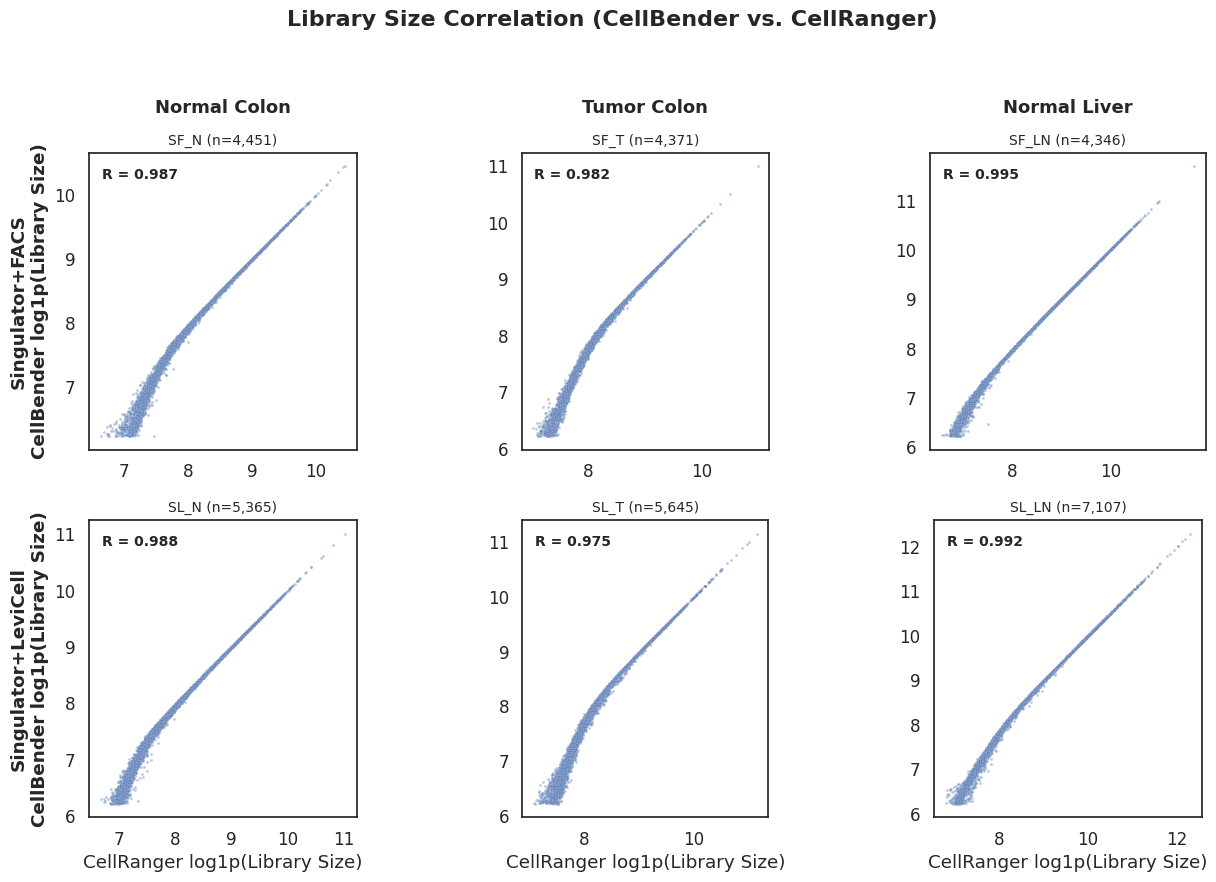

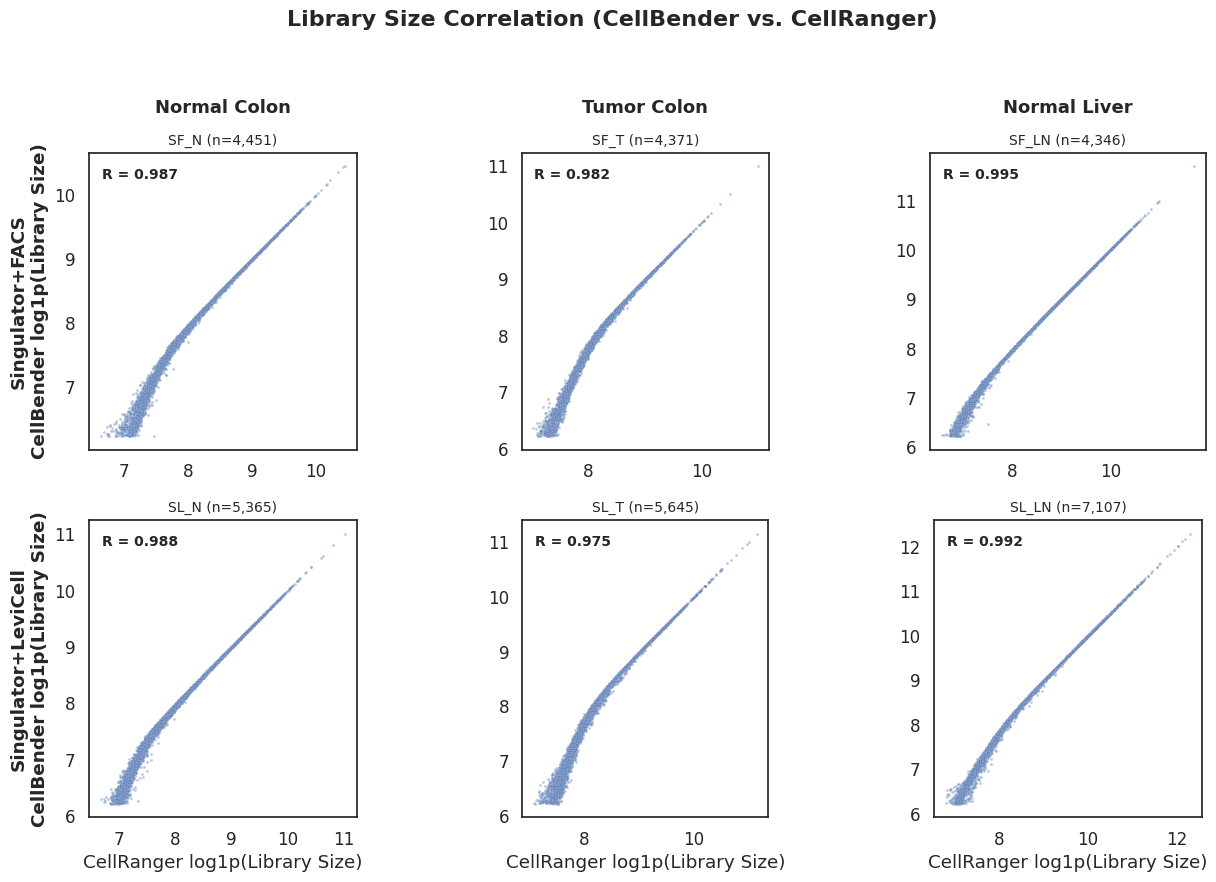

In [105]:
plot_library_size_correlations(
    cellbender_filtered_adatas=cellbender_filtered_adatas,
    cellranger_adatas=cellranger_adatas,
    shared_cells_dict=shared_cellbender_cellranger,
    adata_metadata=adata_metadata,
)

In [108]:
def plot_library_size_histograms(
    cellbender_filtered_adatas: Dict[str, sc.AnnData],
    cellranger_adatas: Dict[str, sc.AnnData],
    shared_cells_dict: Dict[str, sc.AnnData],
    adata_metadata: Dict[str, tuple],  # maps sample -> (tissue, protocol)
    log_x: bool = True,
    log_y: bool = False,
    proportion: bool = False,
    bins: int = 100,
    title: str = "Library Size Distribution (CellBender vs. CellRanger)",
    protocol_color_palette: Dict[str, str] = None,
) -> plt.Figure:
    import collections
    from collections import OrderedDict
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    import matplotlib as mpl

    # Build long-form DataFrame and collect raw values for axis limits
    rows = []
    raw_vals = []
    grid = collections.defaultdict(dict)
    tissue_protocol_pairs = []

    for sample, shared_adata in shared_cells_dict.items():
        tissue, protocol = adata_metadata[sample]
        tissue_protocol_pairs.append((tissue, protocol))
        grid[protocol][tissue] = sample

        shared_cells = shared_adata.obs_names
        cb = cellbender_filtered_adatas[sample][shared_cells].copy()
        cr = cellranger_adatas[sample][shared_cells].copy()

        cb_counts = np.array(cb.X.sum(axis=1)).flatten()
        cr_counts = np.array(cr.X.sum(axis=1)).flatten()

        raw_vals.extend(cb_counts)
        raw_vals.extend(cr_counts)

        if log_x:
            cb_counts = np.log1p(cb_counts)
            cr_counts = np.log1p(cr_counts)

        for val in cb_counts:
            rows.append({
                "Sample": sample,
                "Tissue": tissue,
                "Protocol": "CellBender",
                "Value": val
            })
        for val in cr_counts:
            rows.append({
                "Sample": sample,
                "Tissue": tissue,
                "Protocol": "CellRanger",
                "Value": val
            })

    df = pd.DataFrame(rows)

    # Axis tick formatting
    raw_vals = np.array(raw_vals)
    raw_vals = raw_vals[raw_vals > 0]
    vmin, vmax = raw_vals.min(), raw_vals.max()
    min_exp, max_exp = int(np.floor(np.log10(vmin))), int(np.ceil(np.log10(vmax)))
    xticks_raw = [10**e for e in range(min_exp, max_exp + 1)]
    xticks_log = np.log1p(xticks_raw) if log_x else xticks_raw
    xlims = (np.log1p(vmin), np.log1p(vmax)) if log_x else (vmin, vmax)

    # Unique ordered protocol/tissue
    tissue_order = list(OrderedDict.fromkeys(t for t, _ in tissue_protocol_pairs))
    protocol_order = list(OrderedDict.fromkeys(p for _, p in tissue_protocol_pairs))
    n_rows, n_cols = len(protocol_order), len(tissue_order)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(6 * n_cols, 4.5 * n_rows),
        sharex=True, sharey=True
    )

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if n_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    # Color palette
    unique_protocols = df["Protocol"].unique()
    if protocol_color_palette is None:
        protocol_color_palette = dict(zip(
            unique_protocols,
            sns.color_palette("Set2", len(unique_protocols))
        ))

    sns.set_theme(style="white", font_scale=1.1)
    stat_type = "probability" if proportion else "count"

    # Populate plots
    for row_idx, protocol in enumerate(protocol_order):
        for col_idx, tissue in enumerate(tissue_order):
            ax = axes[row_idx, col_idx]
            sample = grid.get(protocol, {}).get(tissue)
            if sample is None:
                ax.axis("off")
                continue

            data = df[df["Sample"] == sample]
            sns.histplot(
                data=data,
                x="Value",
                hue="Protocol",
                palette=protocol_color_palette,
                bins=bins,
                element="step",
                stat=stat_type,
                common_norm=False,
                legend=False,
                ax=ax,
                linewidth=1,
                alpha=0.6,
            )
            ax.set_title(sample, fontsize=11)
            if row_idx == n_rows - 1:
                ax.set_xlabel("log1p(Library Size)" if log_x else "Library Size")
            else:
                ax.set_xlabel("")
            if col_idx == 0:
                ax.set_ylabel(f"{protocol}\n{'Proportion' if proportion else 'Count'}")
            else:
                ax.set_ylabel("")

            ax.set_xlim(*xlims)
            ax.set_xticks(xticks_log)
            ax.set_xticklabels([f"{x:,}" for x in xticks_raw])

            if log_y:
                ax.set_yscale("log")

    # Add tissue labels above columns
    for col_idx, tissue in enumerate(tissue_order):
        axes[0, col_idx].annotate(
            tissue,
            xy=(0.5, 1.2),
            xycoords='axes fraction',
            ha='center', va='center',
            fontsize=13, weight="bold"
        )

    fig.suptitle(title, fontsize=16, weight="bold")
    legend_elements = [
        mpl.patches.Patch(color=protocol_color_palette[p], label=p)
        for p in unique_protocols
    ]
    fig.legend(
        handles=legend_elements,
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.01, 1.02)
    )
    plt.tight_layout(rect=[0, 0, 0.98, 0.95])
    return fig


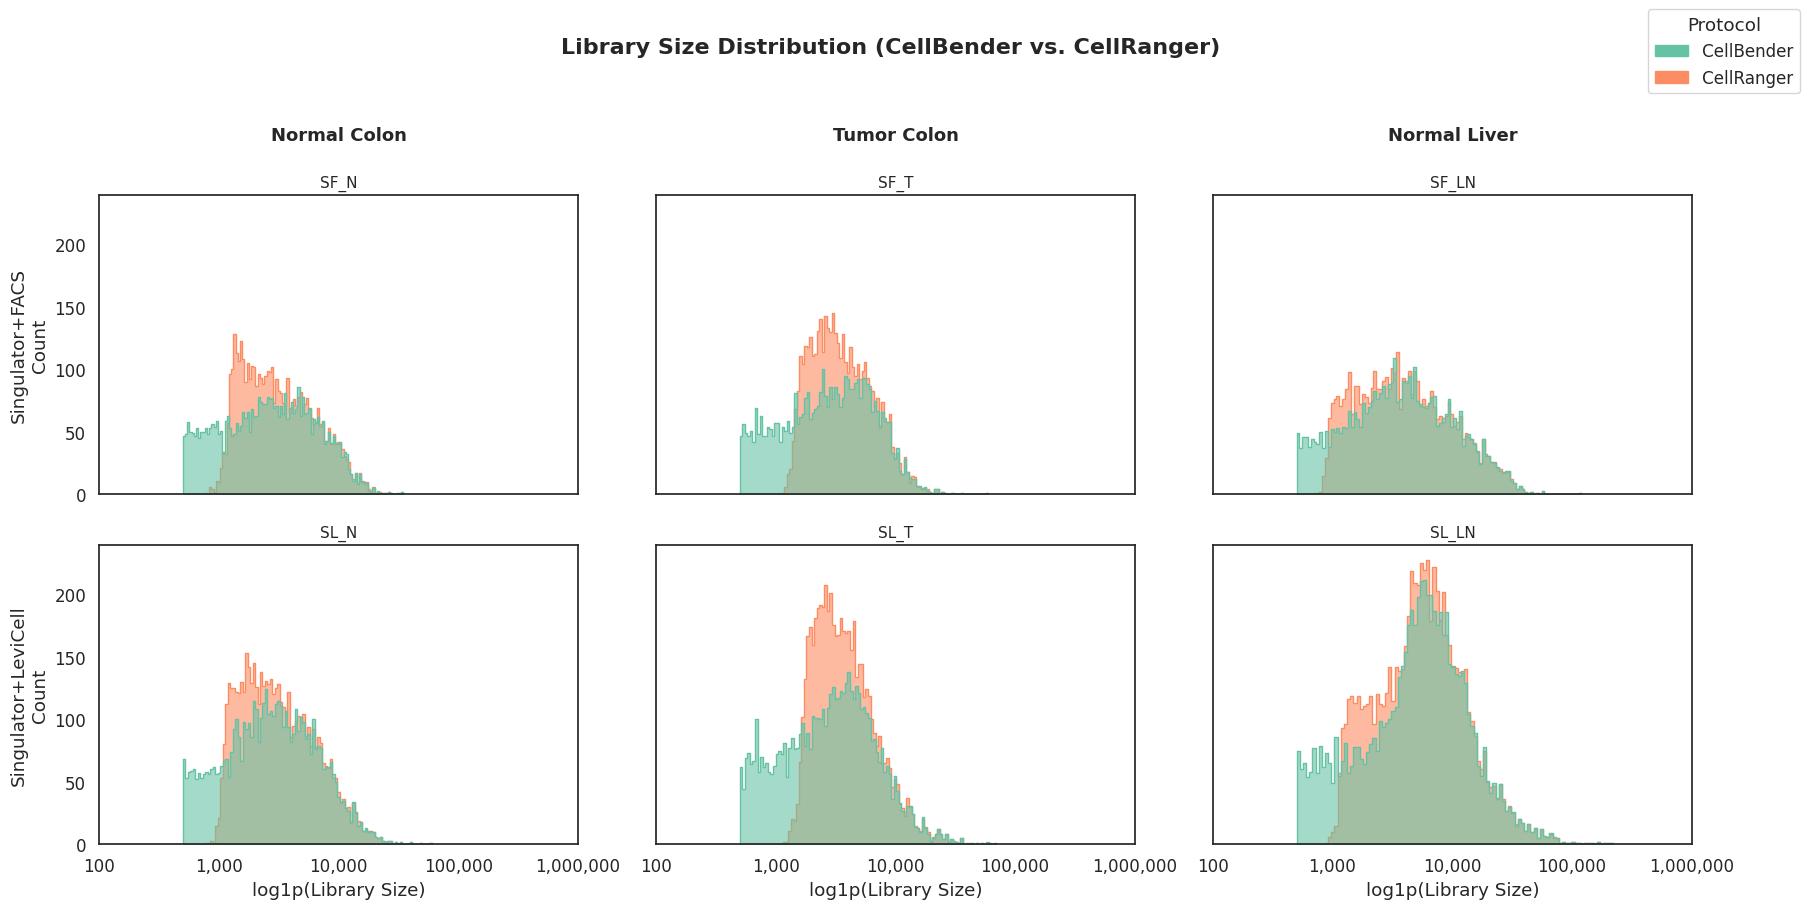

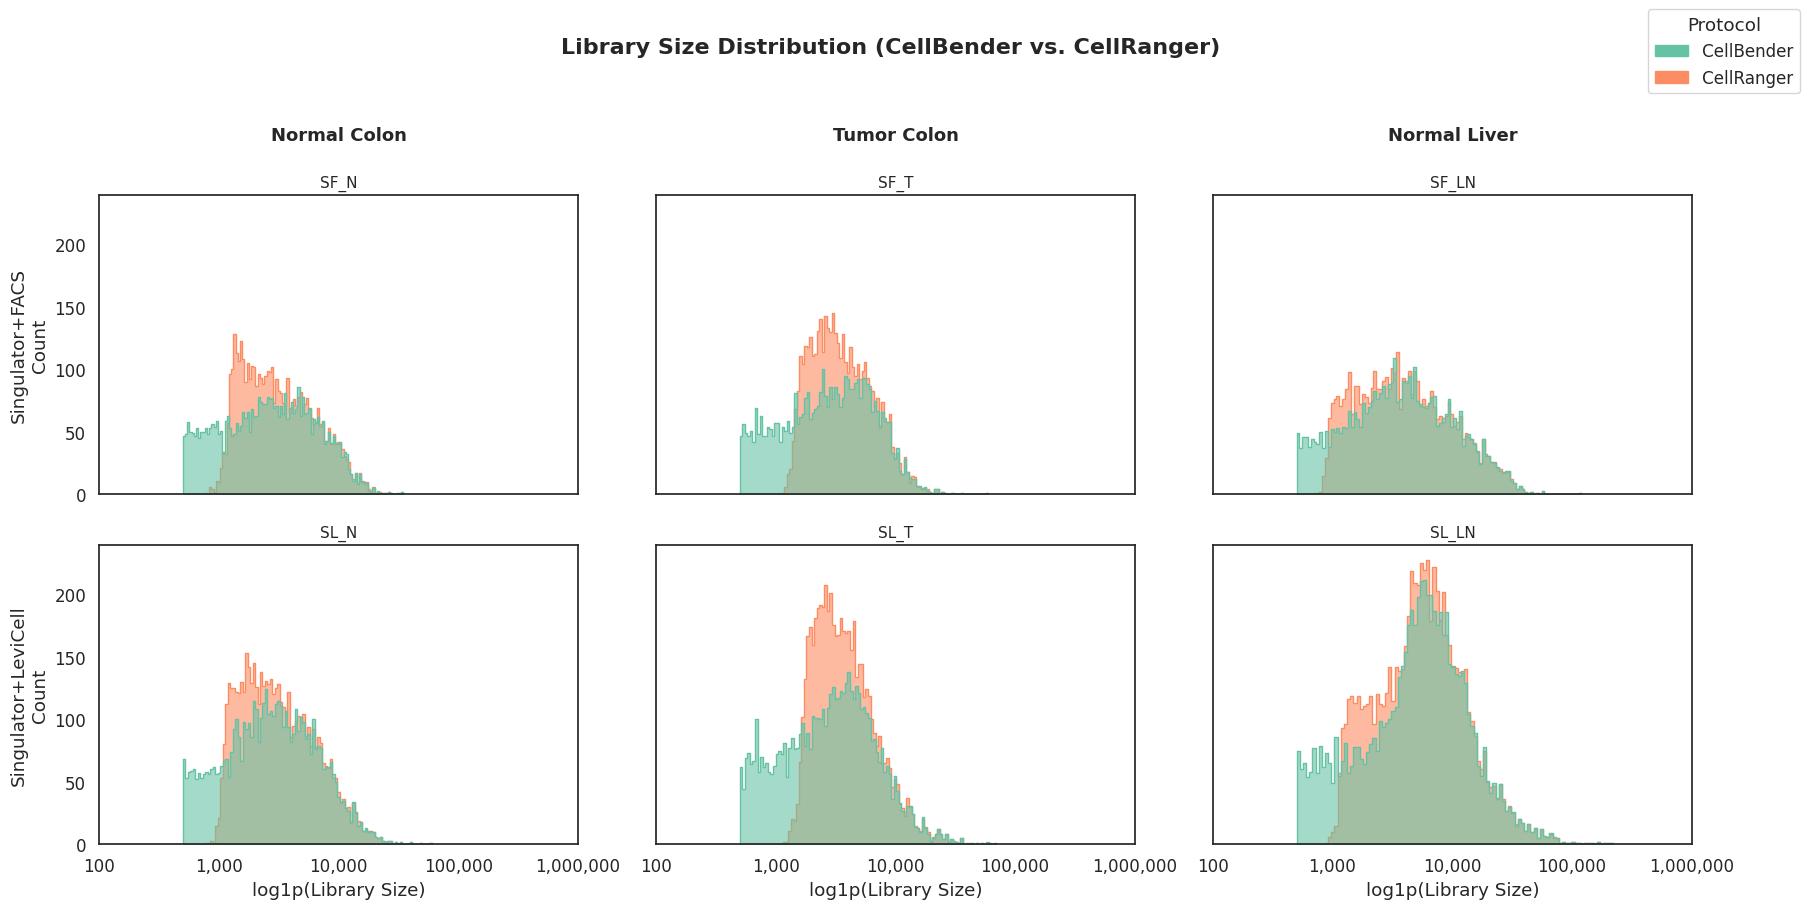

In [109]:
plot_library_size_histograms(
    cellbender_filtered_adatas=cellbender_filtered_adatas,
    cellranger_adatas=cellranger_adatas,
    shared_cells_dict=shared_cellbender_cellranger,
    adata_metadata=adata_metadata,
)

In [110]:
def plot_venn_cell_overlap_per_sample(
    cellbender_filtered_adatas: Dict[str, sc.AnnData],
    cellranger_adatas: Dict[str, sc.AnnData],
    shared_cells_dict: Dict[str, sc.AnnData],
    adata_metadata: Dict[str, tuple],  # sample -> (tissue, protocol)
    title: str = "Cell Overlap per Sample (Venn Diagrams)",
) -> plt.Figure:
    from matplotlib_venn import venn2
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict, OrderedDict

    # Collect insertion-order protocol/tissue from metadata
    tissue_protocol_pairs = [
        adata_metadata[sample] for sample in shared_cells_dict.keys()
    ]
    tissue_order = list(OrderedDict.fromkeys(t for t, _ in tissue_protocol_pairs))
    protocol_order = list(OrderedDict.fromkeys(p for _, p in tissue_protocol_pairs))

    # Build protocol x tissue grid
    grid = defaultdict(dict)
    for sample in shared_cells_dict:
        tissue, protocol = adata_metadata[sample]
        grid[protocol][tissue] = sample

    n_rows = len(protocol_order)
    n_cols = len(tissue_order)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(5.5 * n_cols, 5.5 * n_rows)
    )
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if n_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for row_idx, protocol in enumerate(protocol_order):
        for col_idx, tissue in enumerate(tissue_order):
            ax = axes[row_idx, col_idx]
            sample = grid.get(protocol, {}).get(tissue)

            if sample is None:
                ax.axis("off")
                continue

            cb_cells = set(cellbender_filtered_adatas[sample].obs_names)
            cr_cells = set(cellranger_adatas[sample].obs_names)
            shared_cells = cb_cells & cr_cells

            venn2(
                subsets=(cb_cells, cr_cells),
                set_labels=("CellBender", "CellRanger"),
                ax=ax
            )
            ax.set_title(f"{sample}\nShared: {len(shared_cells):,}", fontsize=11, weight="bold")

        # Label the row with protocol name
        axes[row_idx, 0].annotate(
            protocol,
            xy=(-0.2, 0.5),
            xycoords="axes fraction",
            ha="right",
            va="center",
            fontsize=13,
            weight="bold",
            rotation=90,
        )

    # Label the columns with tissue names
    for col_idx, tissue in enumerate(tissue_order):
        axes[0, col_idx].annotate(
            tissue,
            xy=(0.5, 1.2),
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            fontsize=13,
            weight="bold"
        )

    fig.suptitle(title, fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


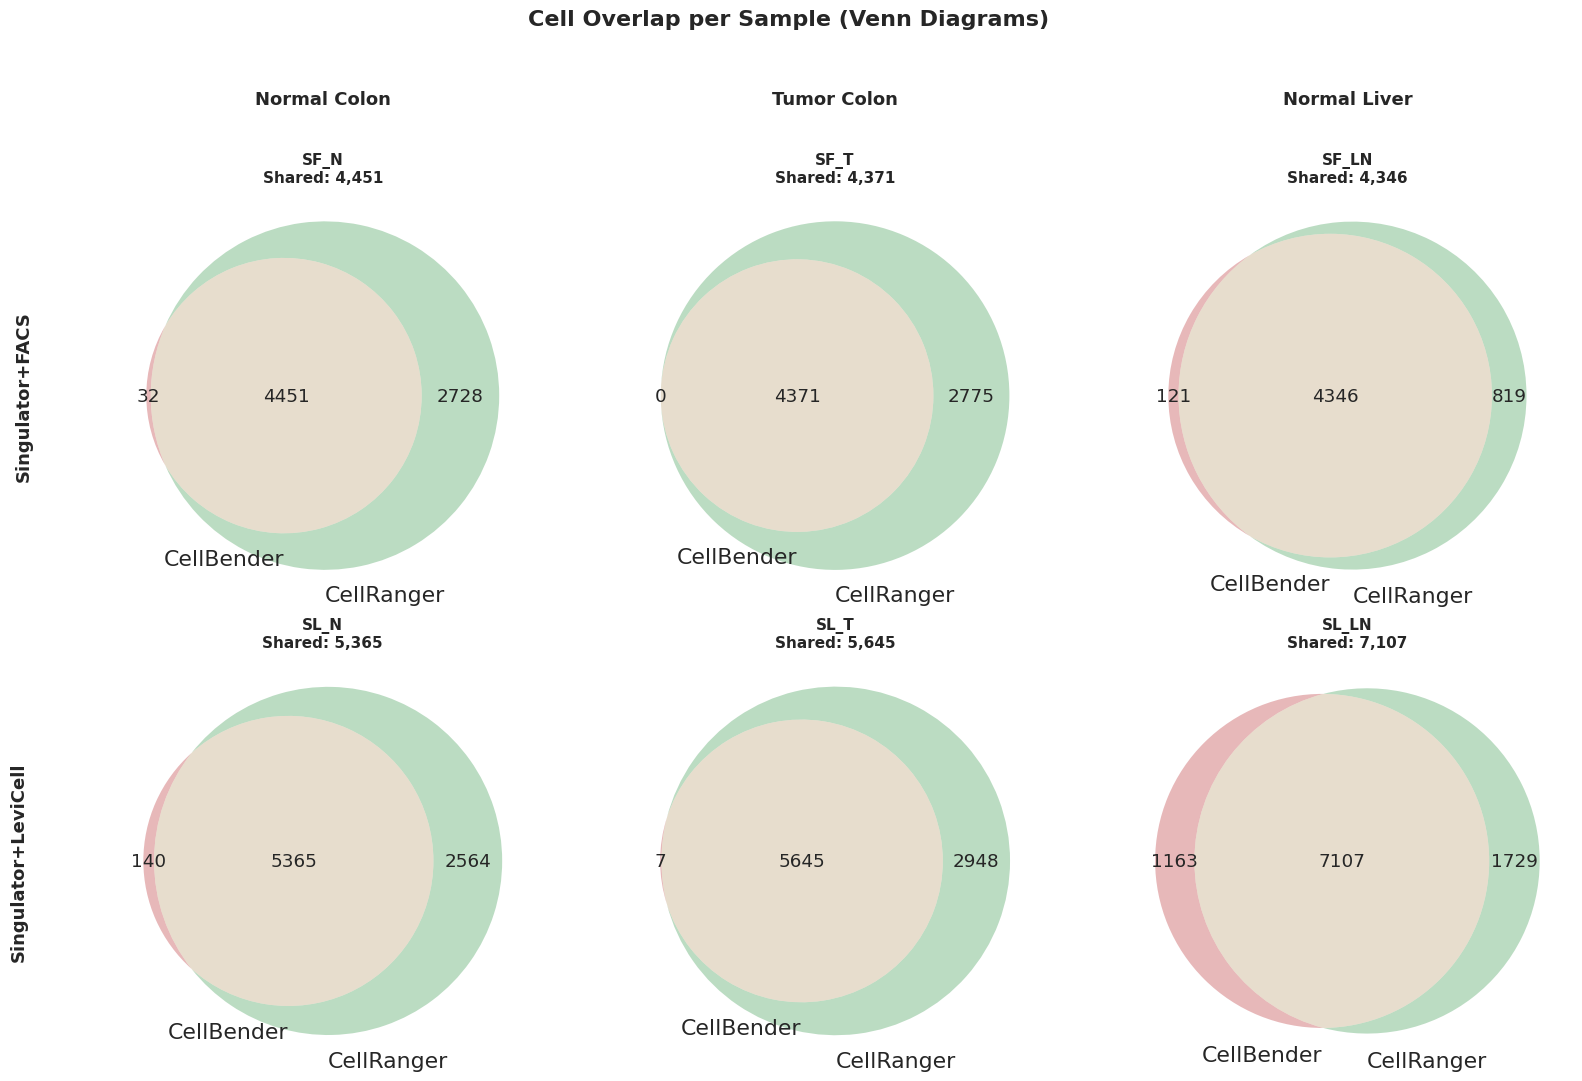

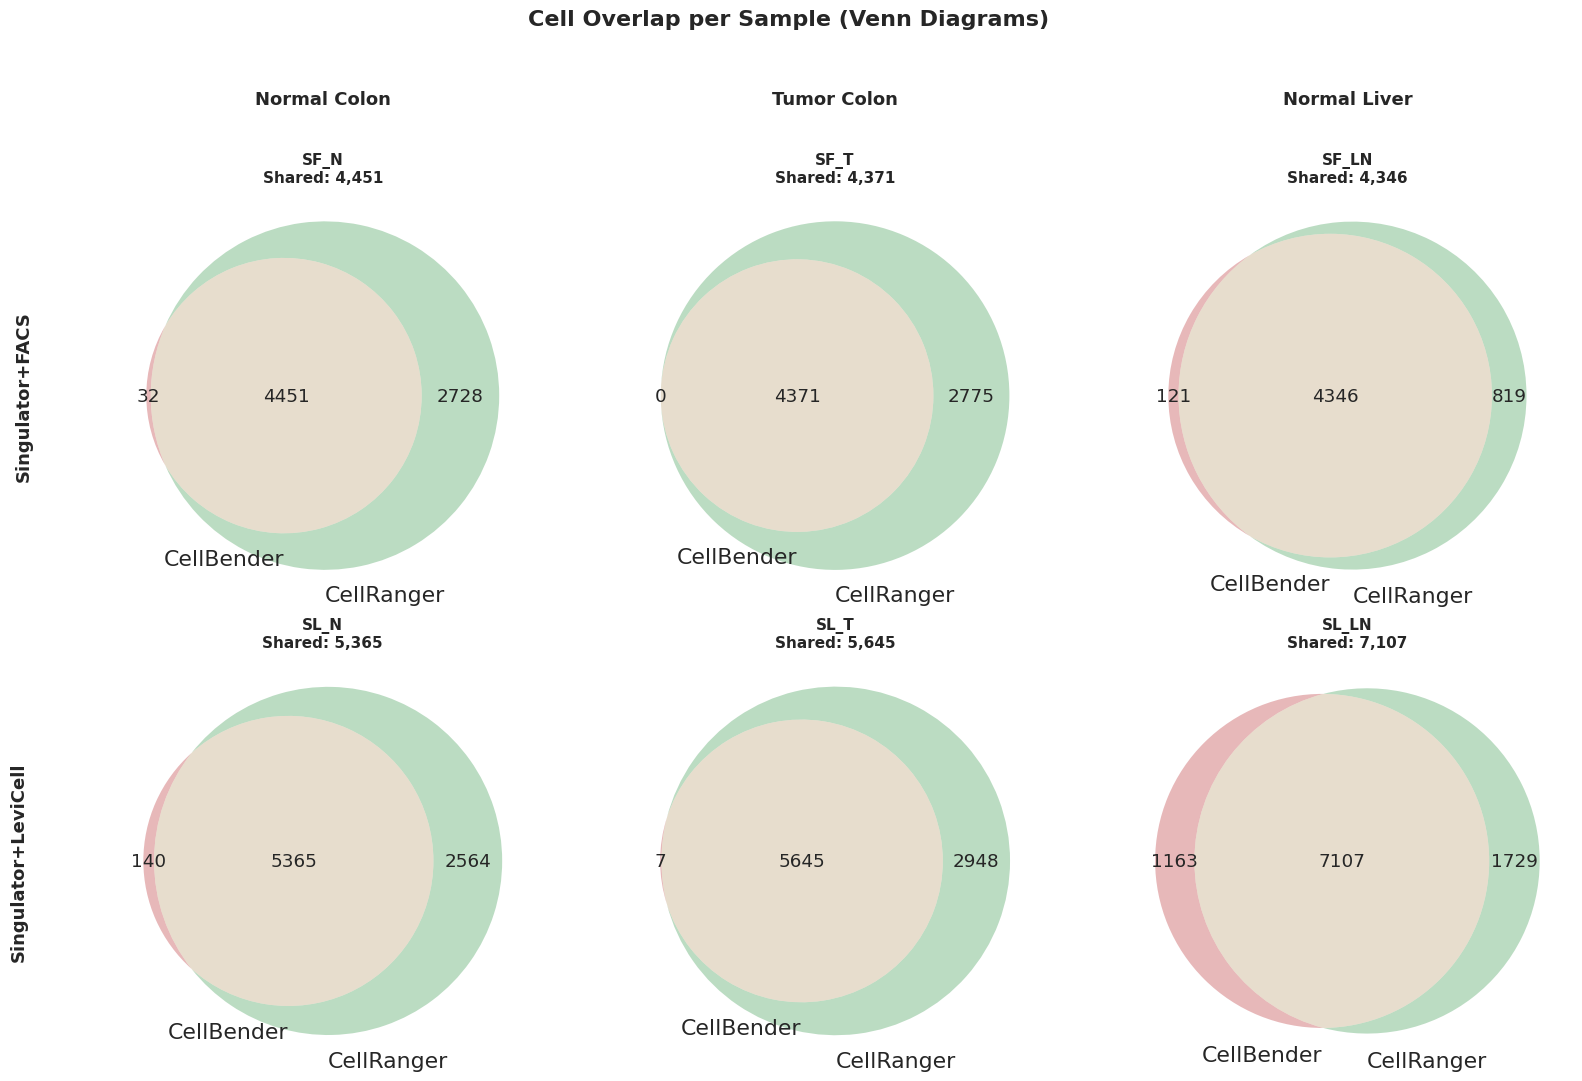

In [111]:
plot_venn_cell_overlap_per_sample(
    cellbender_filtered_adatas=cellbender_filtered_adatas,
    cellranger_adatas=cellranger_adatas,
    shared_cells_dict=shared_cellbender_cellranger,
    adata_metadata=adata_metadata,
)

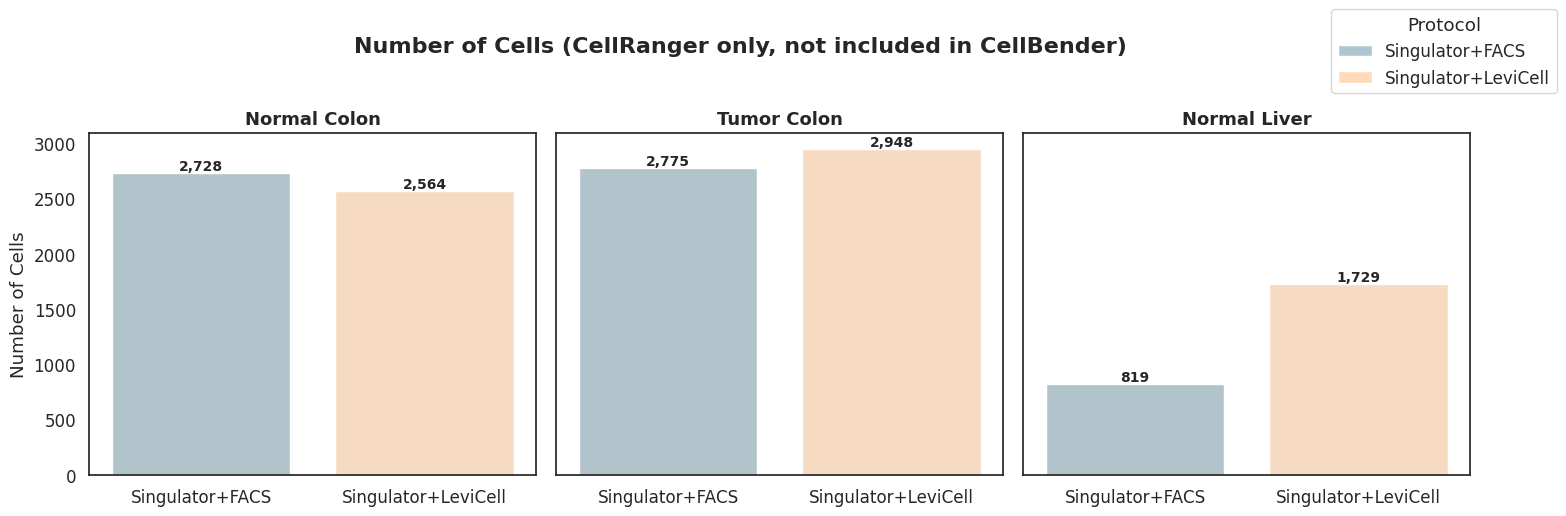

In [112]:
# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=cellranger_only,
    metadata=adata_metadata,
    metric_func=lambda adata: adata.n_obs,
    metric_label="Number of Cells",
    title = "Number of Cells (CellRanger only, not included in CellBender)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "num_cells.png"), bbox_inches="tight")

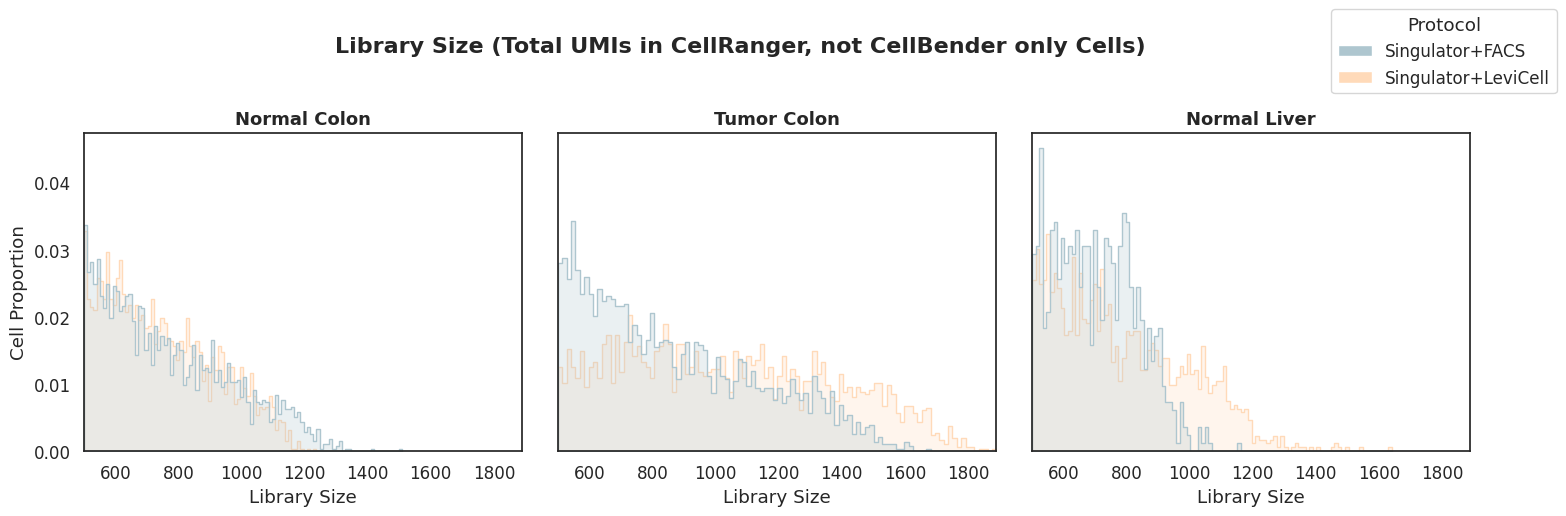

In [114]:
# Plot number of cells
fig = utils.plot_adata_metric_histogram(
    adatas=cellranger_only,
    adata_metadata=adata_metadata,
    field="total_counts",
    axis="obs",
    log_x=False,
    x_label="Library Size",
    title="Library Size (Total UMIs in CellRanger, not CellBender only Cells)",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_hist.png"), bbox_inches="tight"
)

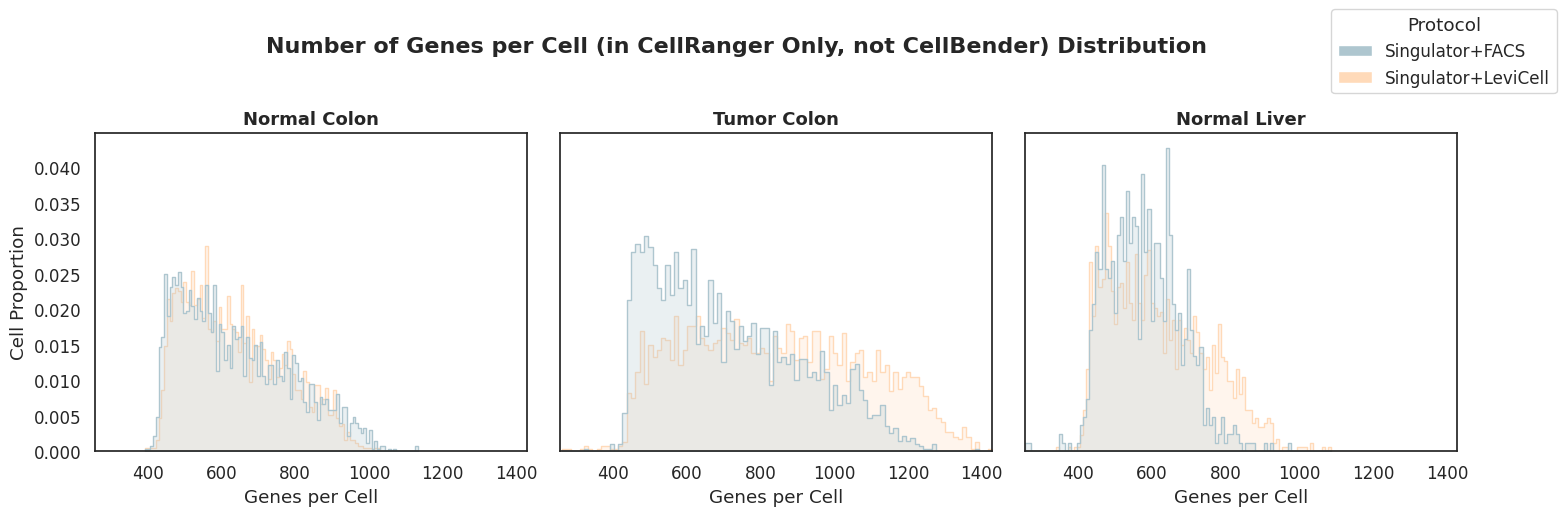

In [117]:
# Plot number of cells
fig = utils.plot_adata_metric_histogram(
    adatas=cellranger_only,
    adata_metadata=adata_metadata,
    field="n_genes_by_counts",
    axis="obs",
    log_x=False,
    x_label="Genes per Cell",
    title="Number of Genes per Cell (in CellRanger Only, not CellBender) Distribution",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "library_size_hist.png"), bbox_inches="tight"
)

In [66]:
cellbender_unfiltered_matched_to_cr_only

{}

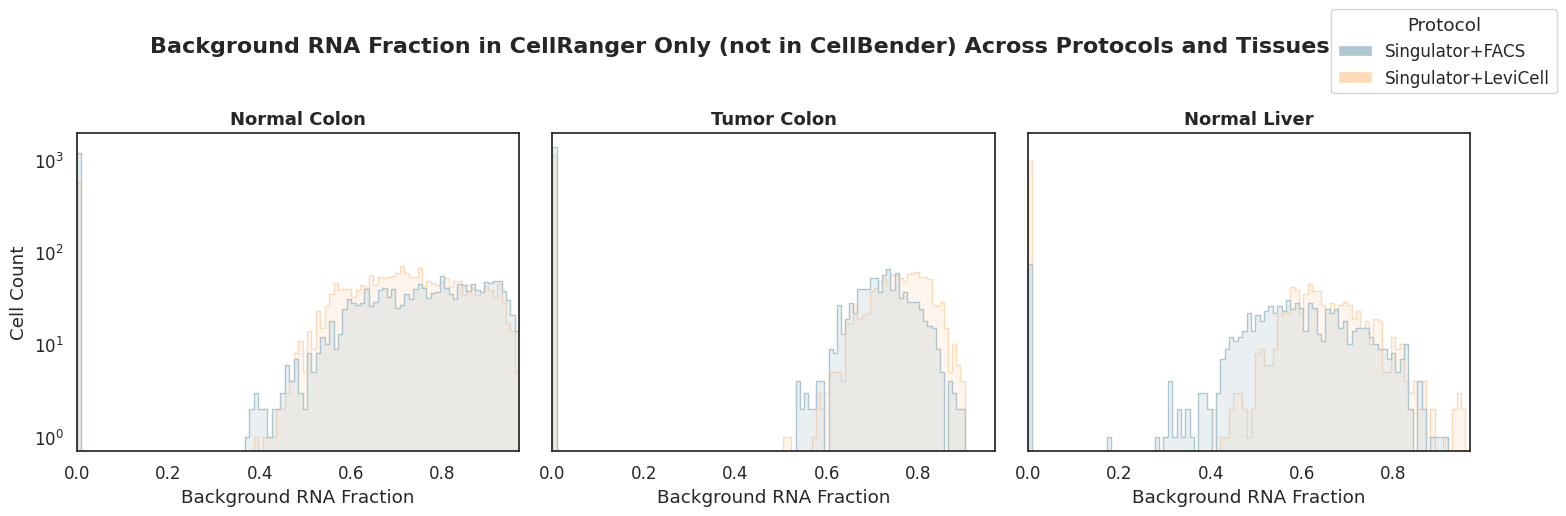

In [118]:
fig = utils.plot_adata_metric_histogram(
    adatas=cellbender_unfiltered_matched_to_cr_only,
    adata_metadata=adata_metadata,
    field="background_fraction",
    axis="obs",
    log_x=False,
    log_y=True,
    x_label="Background RNA Fraction",
    title="Background RNA Fraction in CellRanger Only (not in CellBender) Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "background_fraction_cellranger_only.png"),
    bbox_inches="tight",
)

### Read in CellRanger Combined AnnDatas

In [12]:
combined_by_tissue = {}
for tissue in adata_tissues:
    file_path = os.path.join(
        INPUT_CELLRANGER_FILTERED_COMBINED_BY_TISSUE_DIR, f"{tissue.replace(' ', '_')}_combined_adata.h5ad"
    )
    if os.path.exists(file_path):
        adata = sc.read_h5ad(file_path)
        combined_by_tissue[tissue] = adata
        print(f"Loaded combined AnnData for {tissue} from {file_path}")
        print(f"{tissue} AnnData: {adata}")
    else:
        raise FileNotFoundError(
            f"Combined AnnData for {tissue} not found at {file_path}. Skipping."
        )

Loaded combined AnnData for Normal Colon from ./data/adatas/combined_adatas_filtered_cells/Normal_Colon_combined_adata.h5ad
Normal Colon AnnData: AnnData object with n_obs × n_vars = 15108 × 19437
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'protocol', 'tissue', 'sample', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'downsampled_umi', 'raw_data'
    obsp: 'connectivities', 'distances'
Loaded combined AnnData for Normal Colon from ./data/adatas/combined_adatas_filtered_cells/Normal_Colon_combined_adata.h5ad
Normal Co

In [29]:
# Initialize all to False
for adata in combined_by_tissue.values():
    adata.obs["Removed by CellRanger"] = False

# Update to True where applicable
for sample_key, (folder, tissue, protocol) in samples.items():
    if sample_key in cellbender_filtered_adatas:
        cb_barcodes = set(cellbender_filtered_adatas[sample_key].obs_names)
        adata = combined_by_tissue[tissue]

        sample_mask = adata.obs["sample"] == sample_key
        sample_barcodes = adata.obs_names[sample_mask]
        included_barcodes = ~sample_barcodes.isin(cb_barcodes)

        # Assign only for this subset
        adata.obs.loc[sample_mask, "Removed by CellRanger"] = included_barcodes


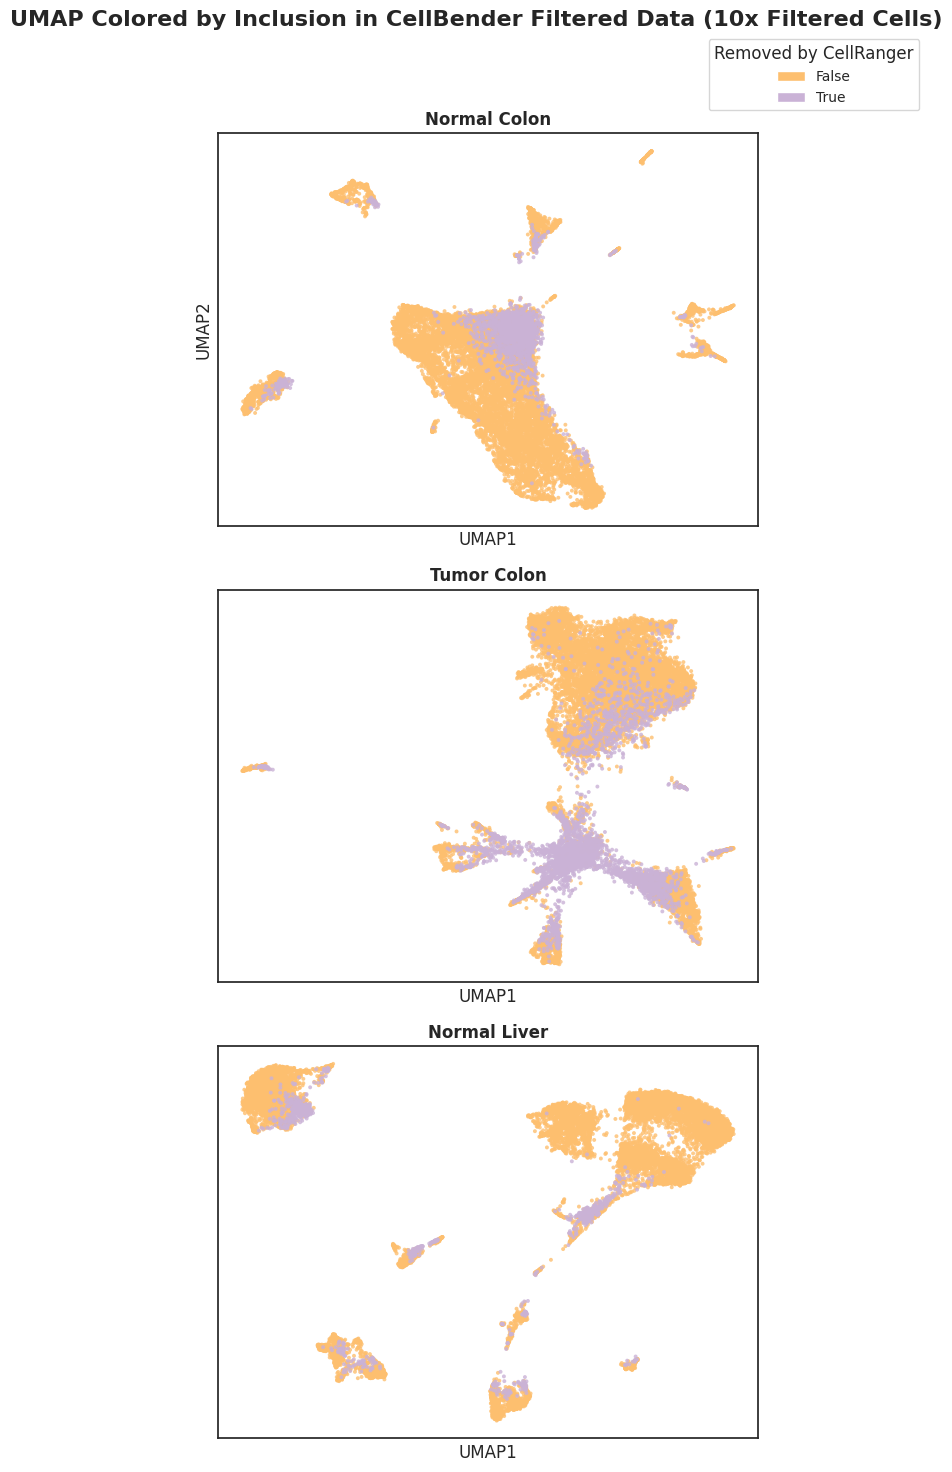

In [30]:
cellbender_inclusion_palette = {
    True: "#CAB2D6",  # soft lavender
    False:  "#FDBF6F",  # warm apricot
}

fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="Removed by CellRanger",
    color_palette=cellbender_inclusion_palette,
    title="UMAP Colored by Inclusion in CellBender Filtered Data (10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
    
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_predicted_doublets_clusters_removed.png"),
    bbox_inches="tight",
)

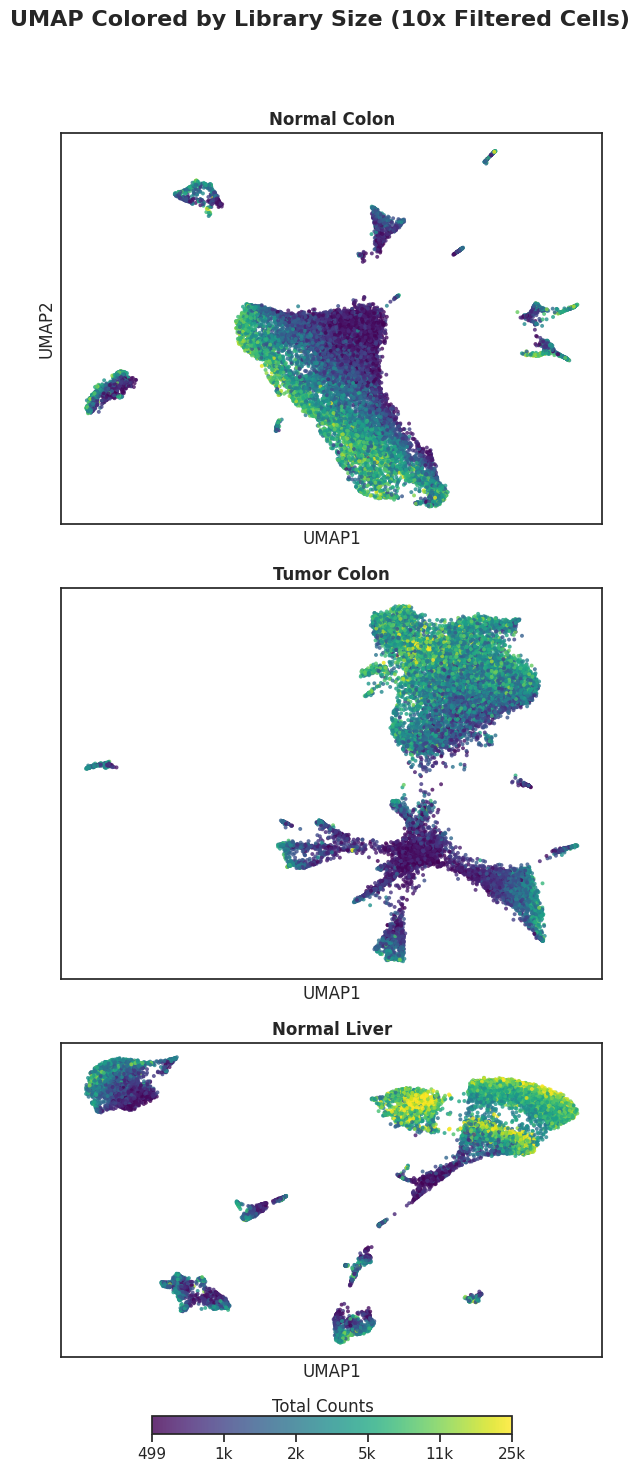

In [26]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="total_counts",
    color_palette="viridis",
    log_scale=True,
    clip_values=(0.0005, 0.99),
    title="UMAP Colored by Library Size (10x Filtered Cells)",
    vertical=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_library_size.png"), bbox_inches="tight"
)

<string>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


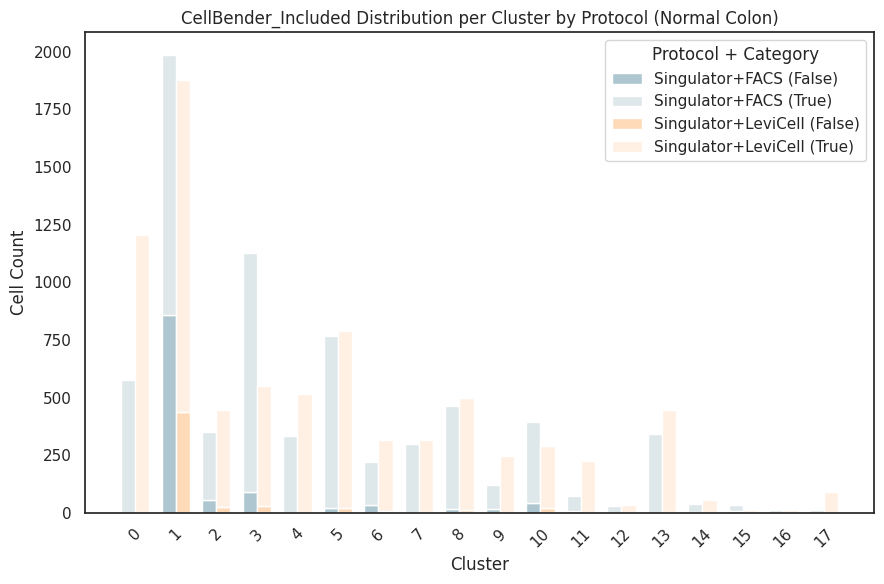

In [ ]:
fig = utils.plot_categorical_stack_by_cluster(
    combined_by_tissue,
    tissue="Normal Colon",
    category_key="CellBender_Included",  # Or any categorical field
    cluster_key="leiden",
    protocol_key="protocol",
    protocol_color_palette=protocol_color_palette,
    highlight_false = True,
)

<string>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


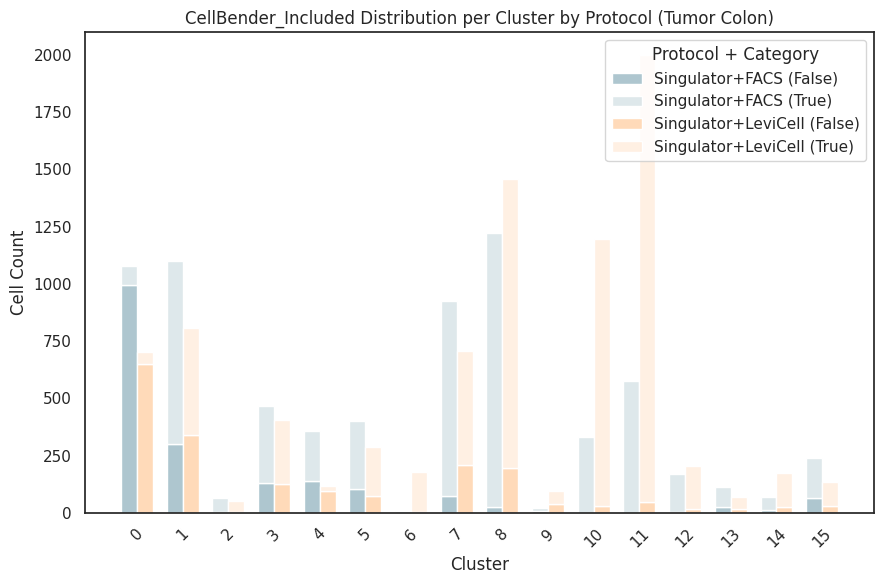

In [54]:
fig = utils.plot_categorical_stack_by_cluster(
    combined_by_tissue,
    tissue="Tumor Colon",
    category_key="CellBender_Included",  # Or any categorical field
    cluster_key="leiden",
    protocol_key="protocol",
    highlight_false=True,
    protocol_color_palette=protocol_color_palette,
)

<string>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


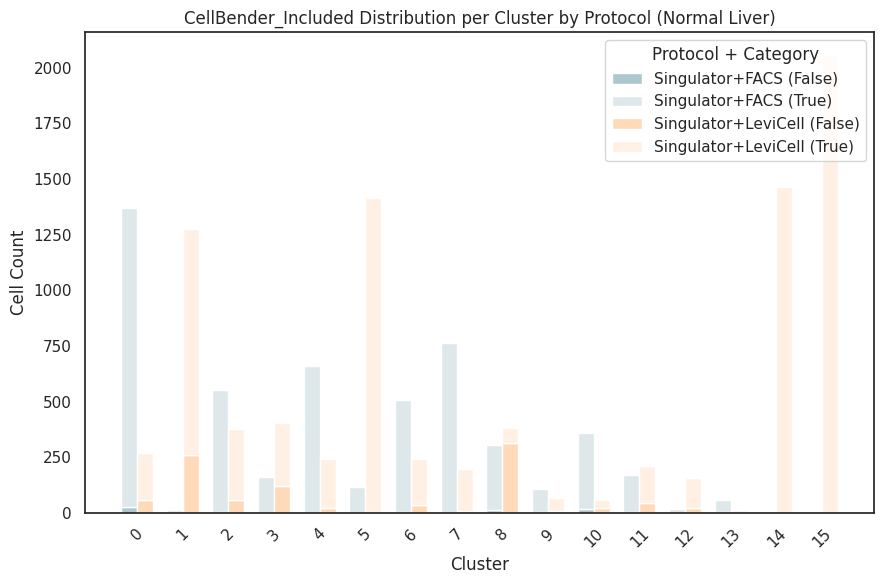

In [55]:
fig = utils.plot_categorical_stack_by_cluster(
    combined_by_tissue,
    tissue="Normal Liver",
    category_key="CellBender_Included",  # Or any categorical field
    cluster_key="leiden",
    protocol_key="protocol",
    highlight_false = True,
    protocol_color_palette=protocol_color_palette,
)